In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#libs
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import os
import gc

import torch 
from torch.utils.data import DataLoader
from torch.utils.cpp_extension import CUDA_HOME

import torchvision
from torchvision.transforms.functional import pil_to_tensor
from torchmetrics import JaccardIndex

#our classes
import utils 
from datasets.dataset_loading import CocoLoader,get_coco_split
import segmentation_models 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import torch
import torchmetrics.functional.detection.iou

# Example segmentation mask predictions and targets
pred = torch.randint(0, 2, (10, 10))  # Simulated prediction mask
target = torch.randint(0, 2, (10, 10))  # Simulated target mask

# Calculate IoU for binary classification
iou = iou(pred, target, num_classes=2, reduction="none")
print(iou)

AttributeError: module 'torchmetrics.functional' has no attribute 'iou'

In [25]:
# CUDA tests and setup

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # might not be viable, check again!
torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("CUDA available:" + str(torch.cuda.is_available()))
print("CUDA_HOME:" + str(CUDA_HOME))

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(available_gpus)
print(torch.cuda.device_count())

CUDA available:True
CUDA_HOME:/home.stud/svobo114/.conda/envs/detect_env_clone
1


In [20]:
transforms = None
coco_train_dataset = CocoLoader(get_coco_split(), transform=transforms)
# len 2014 = 82783
# len 2017 = 118287

loading annotations into memory...
Done (t=12.78s)
creating index...
index created!


In [14]:
sam_wrapper = segmentation_models.SamWrapper(model="b", device="cuda")

In [26]:
# Set batch size and number of workers
batch_size = 7
num_workers = 4

# Clear CUDA cache
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# Create DataLoader from the training dataset
data_loader = coco_train_dataset.instantiate_loader(batch_size=batch_size, num_workers=num_workers)

# large SAM-1 for 20 GB GPU with cca 7 boxes per image      -> batch<=4, (maybe 5 if lucky)
# base SAM-1 for 20 GB  , 7 boxes                           -> batch<=7

In [38]:
for batch in data_loader:
    print(len(batch[0])) #first order is list
    print(batch[0][0].shape) #image in torch format
    print(len(batch[1])) 
    print(batch[1][0].keys()) #target in torch format
    break

print(coco_train_dataset[0])

7
torch.Size([3, 480, 640])
7
dict_keys(['boxes', 'masks', 'categories'])
{'image': tensor([[[  2,   1,   0,  ..., 134, 134, 131],
         [  5,   3,   1,  ..., 137, 135, 131],
         [  1,   0,   0,  ..., 138, 136, 132],
         ...,
         [  3,   6,   7,  ...,   0,   4,  10],
         [  5,   5,   7,  ...,  13,   6,   3],
         [  4,   5,   7,  ...,   1,   2,   2]],

        [[ 24,  23,  22,  ..., 171, 171, 168],
         [ 25,  23,  22,  ..., 174, 172, 168],
         [ 21,  20,  19,  ..., 175, 173, 169],
         ...,
         [  1,   1,   1,  ...,  11,  10,   4],
         [  0,   0,   3,  ...,   8,   2,   2],
         [  0,   0,   3,  ...,   3,   3,   5]],

        [[109, 109, 108,  ..., 197, 197, 195],
         [112, 112, 111,  ..., 200, 198, 194],
         [110, 109, 111,  ..., 201, 199, 195],
         ...,
         [  4,   5,   5,  ...,  37,  36,  32],
         [  6,   4,   4,  ...,  38,  25,  20],
         [  5,   4,   2,  ...,  26,  23,  20]]], dtype=torch.uint8), 'a

In [ ]:
dataset_IoU = JaccardIndex(task="binary")
results = sam_wrapper.infer_masks(
    data_loader, boxes=None, metrics_class=dataset_IoU, batches=10
)
print(dataset_IoU.compute())

In [47]:
batch_max = 10 #7200*7=50400 images cca 1/2 of 2017 dataset
#not up to date with pipeline

# CUDA cleanup before running
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_peak_memory_stats()

dataset_IoU = JaccardIndex(task="binary")  # bg x mask

# run batches
for i, batch in enumerate(data_loader):

    # separate GT for metrics
    gt_boxes = []
    gt_masks = []
    images_to_process = []
    for j in range(len(images_pil)):
        masks_img, boxes_img = utils.coco_masks_boxes(
            metadata[j], api
        )  # load boxes x0,y0,x1,y1
        if len(boxes_img) == 0:
            continue

        boxes_img = torch.Tensor(boxes_img)  # change format and to tensor
        masks_img = masks_img
        gt_boxes.append(boxes_img)
        gt_masks.append(masks_img)
        images_to_process.append(images_pil[j])

    if len(gt_masks) == 0:
        print("no masks in batch")
        continue  # next batch alltogether


    # TODO for now using GT boxes, later detection module HERE
    inferrence_boxes = gt_boxes

    # prepare input for batch
    sam_batched_inputs = []
    for j in range(len(images_to_process)):
        img = np.array(images_to_process[j])
        dict_img = {  # written according to official sam notebook predictor.ipynb
            "image": utils.prepare_image_for_batch(img, resize_transform, sam.device),
            "boxes": resize_transform.apply_boxes_torch(
                inferrence_boxes[j].to(sam.device), img.shape[:2]
            ),
            "original_size": img.shape[:2],
        }
        if len(inferrence_boxes[j]) > 0:
            sam_batched_inputs.append(dict_img)

    # run inference
    batched_output = sam(sam_batched_inputs, multimask_output=True)

    # Take best masks in each image
    for j, dict_output in enumerate(
        batched_output
    ):  # dict_keys(['masks', 'iou_predictions', 'low_res_logits'])
        pred_quality = dict_output["iou_predictions"]
        best = np.argmax(pred_quality.cpu(), axis=1)

        arange = torch.arange(best.shape[0])
        best_masks = dict_output["masks"][arange, best]  # take best mask for each box

        # calculate metric over one
        if len(gt_masks[j]) == 0:
            print("no masks! but " + str(len(gt_boxes[j])) + " boxes")

        dataset_IoU.update(best_masks.cpu(), torch.Tensor(gt_masks[j]))  # both on cpu?

    print(
        "Max GB allocated: "
        + str(torch.cuda.max_memory_allocated() // 1000000000)  # full GB
        + "."
        + str(
            (torch.cuda.max_memory_allocated() % 1000_000_000) // 1_000_000
        )  # 3 digits
    )
    if i >= batch_max:  # just few batches for now, print final IoU
        print("Mean IoU: " + str(dataset_IoU.compute()))
        break


# CUDA cleanup after running
with torch.no_grad():
    gc.collect()

Batch: 0
Max GB allocated: 18.353
Batch: 1
Max GB allocated: 18.353
Batch: 2
Max GB allocated: 18.376
Batch: 3
Max GB allocated: 18.376
Batch: 4
Max GB allocated: 18.432
Batch: 5
Max GB allocated: 18.432
Batch: 6
Max GB allocated: 18.432
Batch: 7
Max GB allocated: 18.432
Batch: 8
Max GB allocated: 18.432
Batch: 9
Max GB allocated: 18.432
Batch: 10
Max GB allocated: 18.432
Mean IoU: tensor(0.7451)


In [43]:
print(1 / 0)

ZeroDivisionError: division by zero

### Working with IoU, recall visualisation

In [6]:
filename = "out/coco_base_thresholds_36235.npy"
#   out/coco_base_thresholds_36235.npy
#   out/coco_full_thresholds_860001.npy
#   out/coco_large_thresholds_36257.npy
with open(filename, "rb") as f:
    thresholds = np.load(f)

num_nan = np.isnan(thresholds).sum()
print("Number of NaN items: ", num_nan)
print("Number of zeroes: ", (thresholds == 0).sum())
thresholds[np.isnan(thresholds)] = 0.

Number of NaN items:  0
Number of zeroes:  15


In [7]:
print(np.mean(thresholds))
print(np.median(thresholds))

0.7593172
0.8124253


In [8]:
thr=0.25
print(np.sum(thresholds>=thr)/len(thresholds))

0.9751621360562992


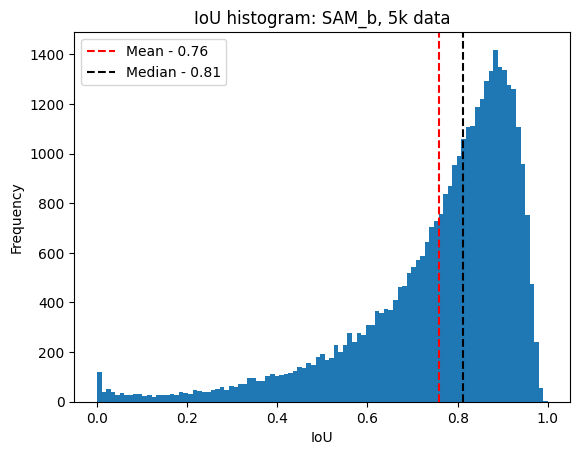

In [9]:
lspace = np.linspace(0.,1.,100)

# Calculate the number of objects in each bin
hist, bins, _ = plt.hist(thresholds, bins=lspace)

# Find the bin index where the mean value of thresholds falls
mean_threshold = np.mean(thresholds)
median_threshold = np.median(thresholds)
plt.axvline(x=mean_threshold, color='red', linestyle='--')
plt.axvline(x=median_threshold, color="black", linestyle="--")
# Add labels and title
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.title('IoU histogram: SAM_b, 5k data')

mean = "{:.2f}".format(mean_threshold)
median = "{:.2f}".format(median_threshold)
plt.legend([f"Mean - {mean}", f"Median - {median}"])
# Show the plot
plt.show()

In [10]:
filename_base = "out/coco_base_thresholds_36235.npy"
filename_large = "out/coco_large_thresholds_36257.npy"

with open(filename_base, "rb") as f:
    base = np.load(f)
with open(filename_large, "rb") as f:
    large = np.load(f)

base[np.isnan(base)] = 0.0
large[np.isnan(large)] = 0.0

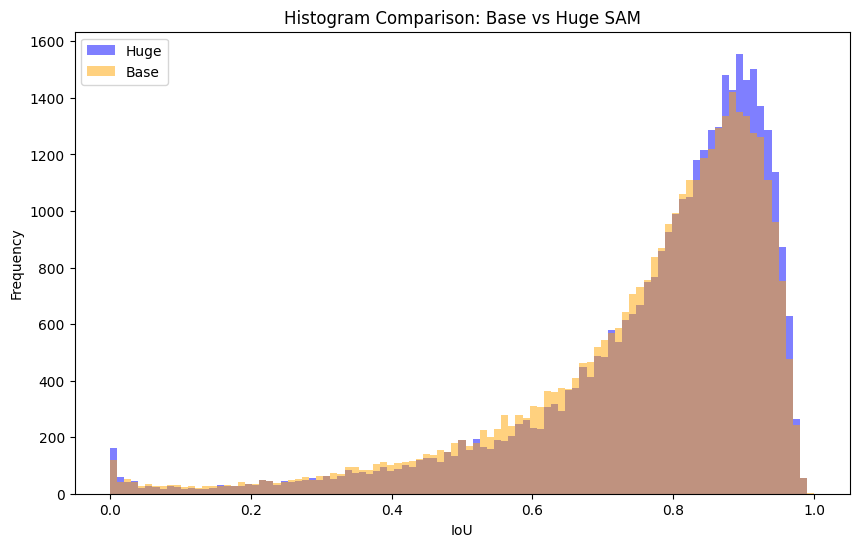

In [12]:
plt.figure(figsize=(10, 6))

# Plot the "large" histogram
bins = np.linspace(0, 1, 100)
plt.hist(large, bins=bins, alpha=0.5, label='Huge', color='blue')

# Plot the "base" histogram
plt.hist(base, bins=bins, alpha=0.5, label='Base', color='orange')

# Add labels and title
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.title('Histogram Comparison: Base vs Huge SAM')

# Add legend
plt.legend()

# Show the plot
plt.show()

### debug IoU??

In [13]:
GT_mask=np.array([0,0,1,1,1])
pred = np.array([0, 1, 1, 1, 1])
jaccard = JaccardIndex('binary')

print(jaccard.forward(torch.Tensor(pred), torch.Tensor(GT_mask)))
print(utils.IoU(pred, GT_mask))


tensor(0.7500)


AttributeError: module 'utils' has no attribute 'IoU'